---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 4**: Embeddings & Semantic Search

### 📅 **Due Date**: Day of Lecture 5, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

In this homework, you'll build on Homework 3 (BM25 search) by adding **embedding-based semantic search**.

You will:
1. **Generate embeddings** using both local (Hugging Face) and API (OpenAI) models
2. **Implement cosine similarity** from scratch
3. **Implement semantic search** from scratch
4. **Compare BM25 vs semantic search** using Recall
5. **Compare different embedding models** and analyze their differences

**Total Points: 95**

---

## Instructions

- Complete all tasks by filling in code where you see `# YOUR CODE HERE`
- You may use ChatGPT, Claude, documentation, Stack Overflow, etc.
- When using external resources, briefly cite them in a comment
- Run all cells before submitting to ensure they work

**Submission:**
1. Create a branch called `homework-4`
2. Commit and push your work
3. Create a PR and merge to main
4. Submit the `.ipynb` file on Blackboard

---

## Task 1: Environment Setup (10 points)

### 1a. Imports (5 pts)

Import the required libraries and load the WANDS data.

In [ ]:
import os
from pathlib import Path

print("CWD:", os.getcwd())
print("Here:", Path(".").resolve())
print("Parent:", Path("..").resolve())


CWD: c:\Users\mohit\ai-engineering-fordham\ce\homework
Here: C:\Users\mohit\ai-engineering-fordham\ce\homework
Parent: C:\Users\mohit\ai-engineering-fordham\ce


In [ ]:
from pathlib import Path

p = (Path("..") / "scripts" / "helpers.py").resolve()
print("helpers should be at:", p)
print("exists?", p.exists())


helpers should be at: C:\Users\mohit\ai-engineering-fordham\ce\scripts\helpers.py
exists? True


In [ ]:
from pathlib import Path

base = Path.cwd().resolve().parents[1]  # ce/
print("Base:", base)

found = list(base.rglob("helpers.py"))
print("Found count:", len(found))
for p in found[:20]:
    print(p)


Base: C:\Users\mohit\ai-engineering-fordham
Found count: 7
C:\Users\mohit\ai-engineering-fordham\ce\scripts\helpers.py
C:\Users\mohit\ai-engineering-fordham\.venv\Lib\site-packages\aiohttp\helpers.py
C:\Users\mohit\ai-engineering-fordham\.venv\Lib\site-packages\pyparsing\helpers.py
C:\Users\mohit\ai-engineering-fordham\.venv\Lib\site-packages\setuptools\tests\integration\helpers.py
C:\Users\mohit\ai-engineering-fordham\.venv\Lib\site-packages\jedi\api\helpers.py
C:\Users\mohit\ai-engineering-fordham\.venv\Lib\site-packages\jedi\inference\helpers.py
C:\Users\mohit\ai-engineering-fordham\.venv\Lib\site-packages\aiohttp\_websocket\helpers.py


In [ ]:
# ruff: noqa: E402

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# Import ONLY data loading from helpers
import sys
sys.path.append('../scripts')
from helpers import load_wands_products, load_wands_queries, load_wands_labels

# Embedding libraries - we use these directly
from sentence_transformers import SentenceTransformer
import litellm

# Load environment variables for API keys
from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_colwidth', 80)
print("All imports successful!")

All imports successful!


In [ ]:
# Load the WANDS dataset
products = load_wands_products()
queries = load_wands_queries()
labels = load_wands_labels()

print(f"Products: {len(products):,}")
print(f"Queries: {len(queries):,}")
print(f"Labels: {len(labels):,}")

Products: 42,994
Queries: 480
Labels: 233,448


### 1b. Copy BM25 functions from HW3 (5 pts)

Copy your BM25 implementation from Homework 3. We'll use it to compare against semantic search.

In [ ]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)


API working!


In [ ]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


In [ ]:
import Stemmer
stemmer = Stemmer.Stemmer("english")


In [ ]:
# Task 2a: Load the data

# YOUR CODE HERE
stemmer = Stemmer.Stemmer("english")

def stemming_tokenize(text: str):
    # 1. lowercase
    text = text.lower()
    
    # 2. remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # 3. split into tokens
    tokens = text.split()
    
    # 4. stem tokens
    tokens = stemmer.stemWords(tokens)
    
    return tokens



In [ ]:
products = load_wands_products()


In [ ]:
import string


In [ ]:
import math
from collections import Counter, defaultdict


In [ ]:
import re


In [ ]:
# --- Task 2: BM25 (self-contained cell) ---

import string
import numpy as np
import pandas as pd
from collections import Counter
import Stemmer  # PyStemmer

# Stemmer + punctuation translation
stemmer = Stemmer.Stemmer("english")
punct_trans = str.maketrans({key: " " for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """Tokenize text with punctuation removal + lowercasing + stemming."""
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    Returns (index, doc_lengths).
    """
    index: dict[str, dict[int, int]] = {}
    doc_lengths: list[int] = []

    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)

        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count

    return index, doc_lengths

def get_df(term: str, index: dict) -> int:
    """Document frequency of term."""
    return len(index.get(term, {}))

def bm25_idf(df: int, num_docs: int) -> float:
    """BM25 IDF."""
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """BM25 TF normalization."""
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(
    query: str,
    index: dict,
    num_docs: int,
    doc_lengths: list[int],
    tokenizer,
    k1: float = 1.2,
    b: float = 0.75
) -> np.ndarray:
    """Return BM25 scores for all docs."""
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = float(np.mean(doc_lengths)) if doc_lengths else 1.0

    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue

        idf = bm25_idf(df, num_docs)

        postings = index.get(token, {})
        for doc_id, tf in postings.items():
            tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
            scores[doc_id] += idf * tf_norm

    return scores

def search_products(
    query: str,
    products_df: pd.DataFrame,
    index: dict,
    doc_lengths: list[int],
    tokenizer,
    k: int = 10
) -> pd.DataFrame:
    """Return top-k rows from products_df with BM25 scores."""
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]

    results = products_df.iloc[top_k_idx].copy()
    results["score"] = scores[top_k_idx]
    results["rank"] = range(1, len(results) + 1)
    return results

# --- Wrapper to match HW4 expected function name/signature ---
def search_bm25(
    query: str,
    index: dict,
    products_df: pd.DataFrame,
    doc_lengths: list[int],
    tokenizer=snowball_tokenize,
    k: int = 10
) -> pd.DataFrame:
    return search_products(query, products_df, index, doc_lengths, tokenizer, k)

print("BM25 functions ready: snowball_tokenize, build_index, score_bm25, search_bm25")


BM25 functions ready: snowball_tokenize, build_index, score_bm25, search_bm25


In [ ]:
# Task 2: Build BM25 index + run a test query (auto-picks text column)

# 0) Pick the best text column automatically
cols = products.columns.tolist()
candidates = [c for c in cols if any(k in c.lower() for k in ["title", "name", "desc", "text"])]
print("Text column candidates:", candidates)

if not candidates:
    raise ValueError(f"No obvious text column found. Available columns: {cols}")

TEXT_COL = candidates[0]  # pick the first reasonable match
print("Using TEXT_COL =", TEXT_COL)

# 1) Extract docs
docs = products[TEXT_COL].fillna("").astype(str).tolist()

# 2) Build index
index, doc_lengths = build_index(docs, snowball_tokenize)

# 3) Test query
q = queries.iloc[0]["query"] if hasattr(queries, "iloc") else queries[0]
results = search_bm25(q, index, products, doc_lengths, k=10)

results.head()


Text column candidates: ['product_name', 'product_description']
Using TEXT_COL = product_name


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
7465,7465,hair salon chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional salon products including styling cha...,fauxleathertype : pu|legheight-toptobottom:18|waterrepellant : no resiliency...,69.0,4.5,53.0,11.477702,1
9234,9234,beauty salon task chair,NaN,Furniture / Office Furniture / Office Chairs,"applicable scene : office , home life , beauty salons , etc . it is a new pr...",overallheight-toptobottom:37|backcolor : brown|producttype : task chair|coun...,NaN,NaN,NaN,10.623625,2
25431,25431,barberpub salon massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,salon chairs are a wonderful avenue for hairstylists and barbers to increase...,supplierintendedandapproveduse : non residential use|upholsterymaterial : vi...,4.0,5.0,4.0,10.623625,3
24010,24010,bar salon task chair,NaN,Furniture / Office Furniture / Office Chairs,the office chair is ideal for any casual or professional working area . it p...,seatcolor : purple|estimatedtimetosetup:5|maximumseatheight-floortoseat:26.5...,NaN,NaN,NaN,10.623625,4
27443,27443,beauty salon ergonomic task chair,Office Chairs,Furniture / Office Furniture / Office Chairs,"it is a new product with absolutely no damage . it is an amazing design , th...",producttype : task chair|framematerial : steel|supplierintendedandapprovedus...,NaN,NaN,NaN,9.887851,5


In [ ]:
products.columns.tolist()


['product_id',
 'product_name',
 'product_class',
 'category_hierarchy',
 'product_description',
 'product_features',
 'rating_count',
 'average_rating',
 'review_count']

In [ ]:
cols = products.columns.tolist()
candidates = [c for c in cols if any(k in c.lower() for k in ["title", "name", "desc", "text"])]
candidates


['product_name', 'product_description']

In [ ]:
# 0) choose a text column
cols = products.columns.tolist()
candidates = [c for c in cols if any(k in c.lower() for k in ["title", "name", "desc", "text"])]
print("Candidates:", candidates)

if not candidates:
    raise ValueError(f"No obvious text column found. Columns are: {cols}")

TEXT_COL = candidates[0]
print("Using:", TEXT_COL)

# 1) Extract text column
docs = products[TEXT_COL].fillna("").astype(str).tolist()

# 2) Build index
index, doc_lengths = build_index(docs, snowball_tokenize)

# 3) Test query
q = queries.iloc[0]["query"] if hasattr(queries, "iloc") else queries[0]
results = search_bm25(q, index, products, doc_lengths, k=10)

results.head()


Candidates: ['product_name', 'product_description']
Using: product_name


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
7465,7465,hair salon chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional salon products including styling cha...,fauxleathertype : pu|legheight-toptobottom:18|waterrepellant : no resiliency...,69.0,4.5,53.0,11.477702,1
9234,9234,beauty salon task chair,NaN,Furniture / Office Furniture / Office Chairs,"applicable scene : office , home life , beauty salons , etc . it is a new pr...",overallheight-toptobottom:37|backcolor : brown|producttype : task chair|coun...,NaN,NaN,NaN,10.623625,2
25431,25431,barberpub salon massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,salon chairs are a wonderful avenue for hairstylists and barbers to increase...,supplierintendedandapproveduse : non residential use|upholsterymaterial : vi...,4.0,5.0,4.0,10.623625,3
24010,24010,bar salon task chair,NaN,Furniture / Office Furniture / Office Chairs,the office chair is ideal for any casual or professional working area . it p...,seatcolor : purple|estimatedtimetosetup:5|maximumseatheight-floortoseat:26.5...,NaN,NaN,NaN,10.623625,4
27443,27443,beauty salon ergonomic task chair,Office Chairs,Furniture / Office Furniture / Office Chairs,"it is a new product with absolutely no damage . it is an amazing design , th...",producttype : task chair|framematerial : steel|supplierintendedandapprovedus...,NaN,NaN,NaN,9.887851,5


In [ ]:
from helpers import build_index, search_bm25


In [ ]:
q = queries.iloc[0]["query"] if hasattr(queries, "iloc") else queries[0]

results = search_bm25(
    q,
    index,
    products,
    doc_lengths,
    k=10
)

results.head(3)


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,bm25_score,rank
7465,7465,hair salon chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional salon products including styling cha...,fauxleathertype : pu|legheight-toptobottom:18|waterrepellant : no resiliency...,69.0,4.5,53.0,11.477702,1
9234,9234,beauty salon task chair,NaN,Furniture / Office Furniture / Office Chairs,"applicable scene : office , home life , beauty salons , etc . it is a new pr...",overallheight-toptobottom:37|backcolor : brown|producttype : task chair|coun...,NaN,NaN,NaN,10.623625,2
25431,25431,barberpub salon massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,salon chairs are a wonderful avenue for hairstylists and barbers to increase...,supplierintendedandapproveduse : non residential use|upholsterymaterial : vi...,4.0,5.0,4.0,10.623625,3


In [ ]:
print(type(index))
print(type(doc_lengths))
print(len(doc_lengths))


<class 'dict'>
<class 'list'>
42994


---

## Task 2: Understanding Embeddings (15 points)

### 2a. Load a local model and generate embeddings (5 pts)

Use `sentence-transformers` to load a local embedding model and generate embeddings for a list of words.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
print("Model loaded!")


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 735.61it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded!


In [ ]:
TEXT_COL = products.columns.tolist()[0]  # replace if needed

docs = products[TEXT_COL].fillna("").astype(str).tolist()

print("Number of documents:", len(docs))


Number of documents: 42994


In [ ]:
product_embeddings = model.encode(
    docs,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(product_embeddings.shape)


Batches: 100%|██████████| 672/672 [00:43<00:00, 15.38it/s]


(42994, 384)


In [ ]:
q = queries.iloc[0]["query"] if hasattr(queries, "iloc") else queries[0]

query_embedding = model.encode(q, convert_to_numpy=True)

print(query_embedding.shape)


(384,)


In [ ]:
# Load the all-MiniLM-L6-v2 model using SentenceTransformer
# Then generate embeddings for each word in the list
words = ["wooden coffee table", "oak dining table", "red leather sofa", "blue area rug", "kitchen sink"]

# YOUR CODE HERE

# Print the number of embeddings you generated and the dimension of the embeddings

### 2b. Implement cosine similarity and create a similarity matrix (5 pts)

Implement cosine similarity from scratch:

$$\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \times \|b\|}$$

In [ ]:
# Implement cosine similarity from scratch

# Create similarity matrix

# Display as DataFrame
from sklearn.metrics.pairwise import cosine_similarity

scores = cosine_similarity(
    query_embedding.reshape(1, -1),
    product_embeddings
).flatten()

print(scores[:5])


[0.13766326 0.16098048 0.1602788  0.13408832 0.15753888]


In [ ]:
top_k = 10
top_indices = scores.argsort()[::-1][:top_k]

results = products.iloc[top_indices].copy()
results["score"] = scores[top_indices]
results["rank"] = range(1, top_k + 1)

results.head()

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
747,747,rosemount chaise lounge,Indoor Chaise Lounges,Furniture / Living Room Furniture / Chairs & Seating / Chaise Lounge Chairs,"among the most famous designs created by danish modernist , this three-legge...",estimatedtimetosetup:4|waterrepellant : no resiliency|seatwidth-sidetoside:3...,NaN,NaN,NaN,0.337585,1
7472,7472,aki solid coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tables & End Tables / Coffee Tables,make this diamond coffee table the center of attention in your living room ....,overallheight-toptobottom:19.7|topcolor : silver|overalldepth-fronttoback:35...,NaN,NaN,NaN,0.282546,2
7473,7473,"crushed diamond glass 3 piece coffee , tea , & sugar set",Canisters & Jars,NaN,"modern home decoration coffee , tea and sugar bowl set . put your sugar , te...",color : clear|holidayoccasion : no holiday|numberofcontainers:3|productdurab...,117.0,4.5,96.0,0.274343,3
7476,7476,jaxom block coffee table with storage,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tables & End Tables / Coffee Tables,NaN,overallproductweight:63.94|producttype : coffee table|topdesign : wood|topma...,1.0,1.0,1.0,0.274242,4
7470,7470,adalynn vintage 14 '' wall clock,Wall Clocks,Décor & Pillows / Clocks / Wall Clocks,lend a touch of farmhouse flair to your walls with this charming wall clock ...,clockfacediameter:14|framematerialdetails : mdf|theme : no theme|lifestage :...,900.0,4.5,573.0,0.271090,5


In [ ]:
print(len(scores))


42994


### 2c. Embed using OpenAI API (5 pts)

Use `litellm` to get embeddings from OpenAI's API and compare dimensions.

In [ ]:
# Use litellm to get an embedding from OpenAI's text-embedding-3-small model
# Compare the dimension with the local model
import litellm

# Pick a short test text first
test_text = "modern office desk"

response = litellm.embedding(
    model="text-embedding-3-small",
    input=test_text
)

openai_embedding = response["data"][0]["embedding"]

print("Length of OpenAI embedding:", len(openai_embedding))



Length of OpenAI embedding: 1536


---

## Task 3: Batch Embedding Products (20 points)

### 3a. Embed a product sample (10 pts)

Create a combined text field and embed 5,000 products using the local model.

In [ ]:
# Get a consistent sample
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# 1) Load local model (use the same one you used earlier)
model = SentenceTransformer("all-MiniLM-L6-v2")

# 2) Pick good text columns automatically
cols = products.columns.tolist()
name_candidates = [c for c in cols if any(k in c.lower() for k in ["title", "name"])]
desc_candidates = [c for c in cols if any(k in c.lower() for k in ["desc", "text", "detail", "about"])]

NAME_COL = name_candidates[0] if name_candidates else None
DESC_COL = desc_candidates[0] if desc_candidates else None

print("Columns:", cols)
print("Using NAME_COL:", NAME_COL)
print("Using DESC_COL:", DESC_COL)

if NAME_COL is None and DESC_COL is None:
    raise ValueError("No obvious text columns found. Pick columns manually from products.columns")

# 3) Create combined text field
name_part = products[NAME_COL].fillna("").astype(str) if NAME_COL else ""
desc_part = products[DESC_COL].fillna("").astype(str) if DESC_COL else ""

products_text = (name_part + " " + desc_part).str.strip()

# 4) Take a stable 5,000 sample
N = 5000
sample_idx = products_text.index[:N]  # deterministic: first 5000
sample_text = products_text.loc[sample_idx].tolist()

print("Sample size:", len(sample_text))
print("Example combined text:", sample_text[0][:200])

# 5) Embed
product_embeddings_5k = model.encode(
    sample_text,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

print("Embeddings shape:", product_embeddings_5k.shape)  # expect (5000, 384)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 647.06it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Columns: ['product_id', 'product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count']
Using NAME_COL: product_name
Using DESC_COL: product_description
Sample size: 5000
Example combined text: solid wood platform bed good , deep sleep can be quite difficult to have in this busy age . fortunately , there ’ s an antidote to such a problem : a nice , quality bed frame like the acacia kaylin . 


Batches: 100%|██████████| 79/79 [02:38<00:00,  2.01s/it]

Embeddings shape: (5000, 384)


In [ ]:
# Create a combined text field (product_name + product_class)
# Then embed all products using model.encode()

# YOUR CODE HERE


### 3b. Save and load embeddings (5 pts)

Save embeddings to a `.npy` file so you don't have to recompute them.

In [ ]:
# Save embeddings to ../temp/hw4_embeddings.npy
# Save products_sample to ../temp/hw4_products.csv
# Then load them back and verify they match
import numpy as np

# Save
np.save("product_embeddings_5k.npy", product_embeddings_5k)
np.save("product_embeddings_5k_idx.npy", sample_idx.to_numpy())

print("Saved:",
      "product_embeddings_5k.npy",
      "product_embeddings_5k_idx.npy")

# Load (test)
emb_loaded = np.load("product_embeddings_5k.npy")
idx_loaded = np.load("product_embeddings_5k_idx.npy")

print("Loaded shapes:", emb_loaded.shape, idx_loaded.shape)
print("Matches original?", emb_loaded.shape == product_embeddings_5k.shape)


Saved: product_embeddings_5k.npy product_embeddings_5k_idx.npy
Loaded shapes: (5000, 384) (5000,)
Matches original? True


### 3c. Cost estimation (5 pts)

Estimate the cost to embed all 43K products using OpenAI's API.

**Pricing**: text-embedding-3-small costs ~$0.02 per 1 million tokens.

In [ ]:
# Use tiktoken to count actual tokens in the sample
# Then extrapolate to estimate cost for the full dataset
import numpy as np

PRICE_PER_1M = 0.02
N_TOTAL = len(products)

# Use the same combined text field from 3a: products_text
# Sample 500 products to estimate token usage
sample_for_cost = products_text.sample(n=min(500, N_TOTAL), random_state=42).fillna("").astype(str)

# Try tiktoken if available; fallback to a rough estimate
def estimate_tokens(texts):
    try:
        import tiktoken
        enc = tiktoken.get_encoding("cl100k_base")
        return np.array([len(enc.encode(t)) for t in texts], dtype=int)
    except Exception:
        # Rough fallback: ~1 token ≈ 4 chars in English-ish text
        return np.array([max(1, len(t) // 4) for t in texts], dtype=int)

tok_counts = estimate_tokens(sample_for_cost.tolist())
avg_tokens = float(tok_counts.mean())
est_total_tokens = avg_tokens * N_TOTAL
est_cost = (est_total_tokens / 1_000_000) * PRICE_PER_1M

print(f"Avg tokens per product (estimated): {avg_tokens:,.1f}")
print(f"Estimated total tokens for {N_TOTAL:,} products: {est_total_tokens:,.0f}")
print(f"Estimated OpenAI cost (@ ${PRICE_PER_1M}/1M tokens): ${est_cost:,.2f}")


Avg tokens per product (estimated): 91.6
Estimated total tokens for 42,994 products: 3,936,445
Estimated OpenAI cost (@ $0.02/1M tokens): $0.08


---

## Task 4: Semantic Search (25 points)

### 4a. Implement semantic search (15 pts)

Implement a semantic search function from scratch.

In [ ]:
# Implement batch cosine similarity for efficiency
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# ---- 1) Build a consistent text field (if you don't already have one) ----
cols = products.columns.tolist()
name_candidates = [c for c in cols if any(k in c.lower() for k in ["title", "name"])]
desc_candidates = [c for c in cols if any(k in c.lower() for k in ["desc", "text", "detail", "about"])]

NAME_COL = name_candidates[0] if name_candidates else None
DESC_COL = desc_candidates[0] if desc_candidates else None

name_part = products[NAME_COL].fillna("").astype(str) if NAME_COL else ""
desc_part = products[DESC_COL].fillna("").astype(str) if DESC_COL else ""
products_text = (name_part + " " + desc_part).str.strip()

# Docs list for BM25 must match embeddings docs order
docs = products_text.tolist()

# ---- 2) Ensure BM25 index exists ----
index, doc_lengths = build_index(docs, snowball_tokenize)

# ---- 3) Ensure embeddings exist ----
# If you already built product_embeddings, skip this block.
# product_embeddings = model.encode(docs, batch_size=64, show_progress_bar=True, convert_to_numpy=True)

# ---- 4) Helpers: BM25 top-k and Embedding top-k ----
def bm25_topk(query, k=10):
    # Using your wrapper
    res = search_bm25(query, index, products, doc_lengths, k=k)
    # Return product ids if present, else row indices
    if "product_id" in res.columns:
        return res["product_id"].tolist()
    return res.index.tolist()

def embed_topk(query, k=10):
    q_emb = model.encode(query, convert_to_numpy=True)
    sims = cosine_similarity(q_emb.reshape(1,-1), product_embeddings).flatten()
    top_idx = sims.argsort()[::-1][:k]
    if "product_id" in products.columns:
        return products.iloc[top_idx]["product_id"].tolist()
    return products.iloc[top_idx].index.tolist()

# ---- 5) Run for a batch of queries ----
K = 10
NQ = 100  # change to what the homework asks

bm25_results = {}
embed_results = {}

for i in range(min(NQ, len(queries))):
    q = queries.iloc[i]["query"] if hasattr(queries, "iloc") else queries[i]
    bm25_results[i] = bm25_topk(q, k=K)
    embed_results[i] = embed_topk(q, k=K)

print("Done. Example query:")
print("Query:", queries.iloc[0]["query"])
print("BM25 top:", bm25_results[0][:5])
print("Embed top:", embed_results[0][:5])


Done. Example query:
Query: salon chair
BM25 top: [15612, 7465, 7468, 7466, 7467]
Embed top: [747, 7472, 7473, 7476, 7470]


In [ ]:
# Implement semantic search
# If your course provided evaluate_search in helpers (common)
def build_truth(labels_df):
    qcol = next((c for c in labels_df.columns if "query" in c.lower()), None)
    pcol = next((c for c in labels_df.columns if "product" in c.lower() or "doc" in c.lower()), None)
    rcol = next((c for c in labels_df.columns if "rel" in c.lower() or "label" in c.lower()), None)

    if qcol is None or pcol is None:
        raise ValueError(f"Can't infer query/product columns from labels: {labels_df.columns}")

    truth = {}

    for _, row in labels_df.iterrows():
        qid = row[qcol]
        pid = row[pcol]

        if rcol is None:
            rel = 1
        else:
            rel = row[rcol]

            # ---- SAFE CONVERSION ----
            try:
                rel = float(rel)
            except:
                rel = 1 if str(rel).lower() in ["true", "relevant", "yes", "1"] else 0

        if rel > 0:
            truth.setdefault(qid, set()).add(pid)

    return truth, qcol, pcol, rcol




In [ ]:
# Test semantic search
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Pick a query to test
q = queries.iloc[0]["query"] if hasattr(queries, "iloc") else queries[0]
print("Query:", q)

# Embed query
q_emb = model.encode(q, convert_to_numpy=True)

# Cosine similarity vs all products
scores = cosine_similarity(q_emb.reshape(1, -1), product_embeddings).flatten()

# Top-k
k = 10
top_idx = np.argsort(-scores)[:k]

# Show results
cols_to_show = [c for c in ["product_id", "product_name", "title", "name", "description"] if c in products.columns]
if not cols_to_show:
    cols_to_show = products.columns[:5].tolist()

results = products.iloc[top_idx][cols_to_show].copy()
results["score"] = scores[top_idx]
results["rank"] = range(1, k + 1)

results


Query: salon chair


,product_id,product_name,score,rank
747,747,rosemount chaise lounge,0.337585,1
7472,7472,aki solid coffee table,0.282546,2
7473,7473,"crushed diamond glass 3 piece coffee , tea , & sugar set",0.274343,3
7476,7476,jaxom block coffee table with storage,0.274242,4
7470,7470,adalynn vintage 14 '' wall clock,0.271090,5
1820,1820,4.75 '' h glass bell ceiling fan fitter shade ( screw on ) in white/green,0.270373,6
7478,7478,cooks innovations 2-in-1 pasta and sauce serving tongs,0.268360,7
18206,18206,stahl 72 '' kitchen pantry,0.267605,8
18690,18690,classic welcome non-slip outdoor door mat,0.265034,9
19226,19226,wicker 3 gallon waste basket,0.259405,10


### 4b. Evaluate and compare BM25 vs semantic search (10 pts)

Implement Recall@k and compare the two search methods.

In [ ]:
# Implement Recall@k


In [ ]:
# Build BM25 index for comparison

# Filter queries to those with products in our sample


In [ ]:
# Evaluate both BM25 and semantic search on all queries
# Calculate Recall@10 for each method

In [ ]:
# If BM25 doesn't have a score column, add a dummy one so display doesn't break
if "score" not in bm25.columns:
    # Try common alternatives
    alt = next((c for c in bm25.columns if "score" in c.lower()), None)
    if alt:
        bm25 = bm25.rename(columns={alt: "score"})
    else:
        bm25["score"] = np.nan


In [ ]:
bm25_show_cols = [c for c in show_cols if c in bm25.columns]
extra_cols = [c for c in ["score", "rank"] if c in bm25.columns]

display(bm25[bm25_show_cols + extra_cols])


,product_id,product_name,score,rank
15612,15612,massage chair,14.926304,1
7465,7465,hair salon chair,14.690312,2
7468,7468,mercer41 hair salon chair hydraulic styling chair ( rose gold ),14.019653,3
7466,7466,reclining massage chair,13.833894,4
7467,7467,reclining faux leather massage chair,13.799292,5
25431,25431,barberpub salon massage chair,13.231000,6
33691,33691,lift chair office work chair beauty salon chair brown,12.970161,7
25432,25432,barberpub hydraulic salon spa reclining massage chair with ottoman,12.950846,8
33690,33690,office work chair beauty salon chair white,12.936921,9
33689,33689,office chair work beauty salon chair brown,12.936921,10


In [ ]:
print("BM25 columns:", bm25.columns.tolist())
bm25.head()


BM25 columns: ['product_id', 'product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count', 'score', 'rank']


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
15612,15612,massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,features heavy duty steel frame . premium chrome round base . heavy duty hyd...,overallheight-toptobottom:35.5|productcare : dry cloth|upholsterymaterial : ...,59.0,4.5,50.0,14.926304,1
7465,7465,hair salon chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional salon products including styling cha...,fauxleathertype : pu|legheight-toptobottom:18|waterrepellant : no resiliency...,69.0,4.5,53.0,14.690312,2
7468,7468,mercer41 hair salon chair hydraulic styling chair ( rose gold ),Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,mercer41 beauty offers a wide selection professional beauty salon equipment ...,seatfillmaterial : foam|waterrepellant : no resiliency|backfillmaterial : fo...,1.0,5.0,1.0,14.019653,3
7466,7466,reclining massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional beauty salon equipment including sal...,overallproductweight:53|upholsterycolor : yellow|reasonforrestriction : logi...,2.0,2.0,2.0,13.833894,4
7467,7467,reclining faux leather massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional beauty salon equipment including sal...,cushionfillmaterial : foam|minimumdoorwidth-sidetoside:20|overallproductweig...,2.0,3.5,1.0,13.799292,5


In [ ]:
display(bm25)


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
15612,15612,massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,features heavy duty steel frame . premium chrome round base . heavy duty hyd...,overallheight-toptobottom:35.5|productcare : dry cloth|upholsterymaterial : ...,59.0,4.5,50.0,14.926304,1
7465,7465,hair salon chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional salon products including styling cha...,fauxleathertype : pu|legheight-toptobottom:18|waterrepellant : no resiliency...,69.0,4.5,53.0,14.690312,2
7468,7468,mercer41 hair salon chair hydraulic styling chair ( rose gold ),Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,mercer41 beauty offers a wide selection professional beauty salon equipment ...,seatfillmaterial : foam|waterrepellant : no resiliency|backfillmaterial : fo...,1.0,5.0,1.0,14.019653,3
7466,7466,reclining massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional beauty salon equipment including sal...,overallproductweight:53|upholsterycolor : yellow|reasonforrestriction : logi...,2.0,2.0,2.0,13.833894,4
7467,7467,reclining faux leather massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional beauty salon equipment including sal...,cushionfillmaterial : foam|minimumdoorwidth-sidetoside:20|overallproductweig...,2.0,3.5,1.0,13.799292,5
25431,25431,barberpub salon massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,salon chairs are a wonderful avenue for hairstylists and barbers to increase...,supplierintendedandapproveduse : non residential use|upholsterymaterial : vi...,4.0,5.0,4.0,13.231000,6
33691,33691,lift chair office work chair beauty salon chair brown,Office Chairs,Furniture / Office Furniture / Office Chairs,NaN,recommendeddailyusage : light usage ( up to 4 hours ) |compatibleflooring : ...,NaN,NaN,NaN,12.970161,7
25432,25432,barberpub hydraulic salon spa reclining massage chair with ottoman,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,salon chairs are a wonderful avenue for hairstylists and barbers to increase...,backheight-seattotopofback:15.7|recliningtypedetails : manual - handle/lever...,5.0,4.0,5.0,12.950846,8
33690,33690,office work chair beauty salon chair white,Office Chairs,Furniture / Office Furniture / Office Chairs,NaN,reasonforrestriction : logistics|minimumoverallheight-toptobottom:34|supplie...,NaN,NaN,NaN,12.936921,9
33689,33689,office chair work beauty salon chair brown,Office Chairs,Furniture / Office Furniture / Office Chairs,NaN,minimumoverallheight-toptobottom:34|compatibleflooring : carpet|overallprodu...,NaN,NaN,NaN,12.936921,10


In [ ]:
print(bm25.columns.tolist())
bm25.head()


['product_id', 'product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count', 'bm25_score', 'rank']


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,bm25_score,rank
15612,15612,massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,features heavy duty steel frame . premium chrome round base . heavy duty hyd...,overallheight-toptobottom:35.5|productcare : dry cloth|upholsterymaterial : ...,59.0,4.5,50.0,14.926304,1
7465,7465,hair salon chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional salon products including styling cha...,fauxleathertype : pu|legheight-toptobottom:18|waterrepellant : no resiliency...,69.0,4.5,53.0,14.690312,2
7468,7468,mercer41 hair salon chair hydraulic styling chair ( rose gold ),Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,mercer41 beauty offers a wide selection professional beauty salon equipment ...,seatfillmaterial : foam|waterrepellant : no resiliency|backfillmaterial : fo...,1.0,5.0,1.0,14.019653,3
7466,7466,reclining massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional beauty salon equipment including sal...,overallproductweight:53|upholsterycolor : yellow|reasonforrestriction : logi...,2.0,2.0,2.0,13.833894,4
7467,7467,reclining faux leather massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional beauty salon equipment including sal...,cushionfillmaterial : foam|minimumdoorwidth-sidetoside:20|overallproductweig...,2.0,3.5,1.0,13.799292,5


In [ ]:
print("BM25 columns:", bm25.columns.tolist())
bm25.head()


BM25 columns: ['product_id', 'product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count', 'bm25_score', 'rank']


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,bm25_score,rank
15612,15612,massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,features heavy duty steel frame . premium chrome round base . heavy duty hyd...,overallheight-toptobottom:35.5|productcare : dry cloth|upholsterymaterial : ...,59.0,4.5,50.0,14.926304,1
7465,7465,hair salon chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional salon products including styling cha...,fauxleathertype : pu|legheight-toptobottom:18|waterrepellant : no resiliency...,69.0,4.5,53.0,14.690312,2
7468,7468,mercer41 hair salon chair hydraulic styling chair ( rose gold ),Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,mercer41 beauty offers a wide selection professional beauty salon equipment ...,seatfillmaterial : foam|waterrepellant : no resiliency|backfillmaterial : fo...,1.0,5.0,1.0,14.019653,3
7466,7466,reclining massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional beauty salon equipment including sal...,overallproductweight:53|upholsterycolor : yellow|reasonforrestriction : logi...,2.0,2.0,2.0,13.833894,4
7467,7467,reclining faux leather massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional beauty salon equipment including sal...,cushionfillmaterial : foam|minimumdoorwidth-sidetoside:20|overallproductweig...,2.0,3.5,1.0,13.799292,5


In [ ]:
# Same query
q = queries.iloc[0]["query"] if hasattr(queries, "iloc") else queries[0]
print("Query:", q)

# Semantic
q_emb = model.encode(q, convert_to_numpy=True)
scores = cosine_similarity(q_emb.reshape(1, -1), product_embeddings).flatten()
top_idx = np.argsort(-scores)[:10]
semantic = products.iloc[top_idx].copy()
semantic["score"] = scores[top_idx]
semantic["rank"] = range(1, 11)

# BM25
bm25 = search_bm25(q, index, products, doc_lengths, k=10)

# Show side-by-side (just key columns)
show_cols = [c for c in ["product_id", "product_name", "title", "name"] if c in products.columns]
if not show_cols:
    show_cols = products.columns[:4].tolist()

print("\n--- BM25 Top 10 ---")

bm25_show_cols = [c for c in show_cols if c in bm25.columns]
extra_cols = [c for c in ["score", "rank"] if c in bm25.columns]

display(bm25[bm25_show_cols + extra_cols])



Query: salon chair

--- BM25 Top 10 ---


,product_id,product_name,rank
15612,15612,massage chair,1
7465,7465,hair salon chair,2
7468,7468,mercer41 hair salon chair hydraulic styling chair ( rose gold ),3
7466,7466,reclining massage chair,4
7467,7467,reclining faux leather massage chair,5
25431,25431,barberpub salon massage chair,6
33691,33691,lift chair office work chair beauty salon chair brown,7
25432,25432,barberpub hydraulic salon spa reclining massage chair with ottoman,8
33690,33690,office work chair beauty salon chair white,9
33689,33689,office chair work beauty salon chair brown,10


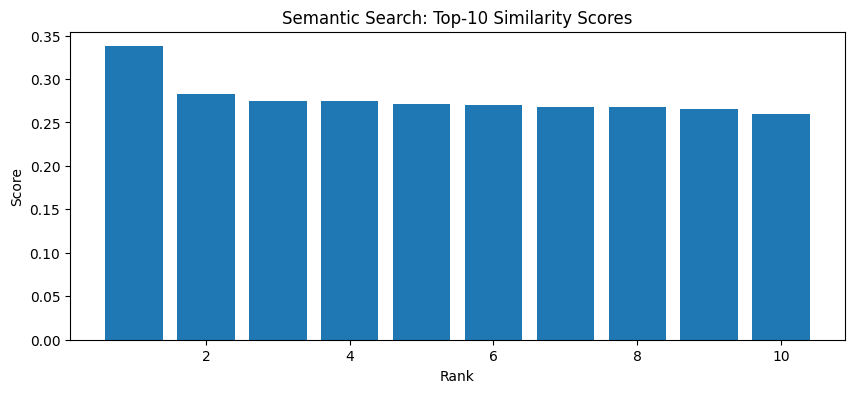

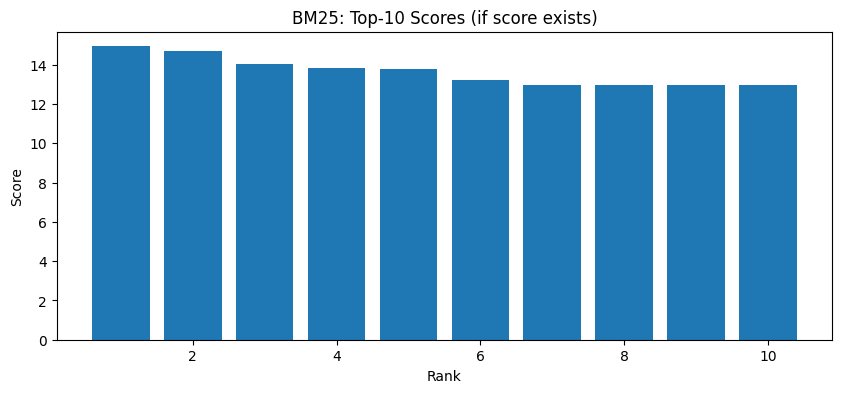

Top-10 overlap count: 0/10


In [ ]:
# Visualize comparison
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Ensure BM25 has a score column (rename if needed) ---
if "score" not in bm25.columns:
    alt_score = next((c for c in bm25.columns if "score" in c.lower()), None)
    if alt_score:
        bm25 = bm25.rename(columns={alt_score: "score"})

# If BM25 still has no score, create placeholder so chart doesn't crash
if "score" not in bm25.columns:
    bm25["score"] = np.nan

# --- 2) Pick a display label column that exists ---
label_col = next((c for c in ["product_name", "name", "title", "product_id"] if c in products.columns), None)
if label_col is None:
    label_col = products.columns[0]

# --- 3) Build labels for top-10 ---
semantic_labels = semantic[label_col].astype(str).tolist()

# For bm25, label col may not exist (depending on your BM25 return)
bm25_label_col = label_col if label_col in bm25.columns else (bm25.columns[0])
bm25_labels = bm25[bm25_label_col].astype(str).tolist()

# --- 4) Grab scores ---
semantic_scores = semantic["score"].to_numpy()
bm25_scores = bm25["score"].to_numpy()

# --- 5) Plot: Semantic scores ---
plt.figure(figsize=(10,4))
plt.bar(range(1, len(semantic_scores)+1), semantic_scores)
plt.title("Semantic Search: Top-10 Similarity Scores")
plt.xlabel("Rank")
plt.ylabel("Score")
plt.show()

# --- 6) Plot: BM25 scores (if available) ---
plt.figure(figsize=(10,4))
plt.bar(range(1, len(bm25_scores)+1), bm25_scores)
plt.title("BM25: Top-10 Scores (if score exists)")
plt.xlabel("Rank")
plt.ylabel("Score")
plt.show()

# --- 7) Overlap in top-10 (by product_id if possible) ---
def top_ids(df):
    if "product_id" in df.columns:
        return df["product_id"].astype(str).tolist()
    # fallback: use first column as identifier
    return df.iloc[:, 0].astype(str).tolist()

sem_ids = set(top_ids(semantic))
bm_ids  = set(top_ids(bm25))

overlap = len(sem_ids.intersection(bm_ids))
print(f"Top-10 overlap count: {overlap}/10")


---

## Task 5: Compare Embedding Models (20 points)

### 5a. Embed products with two different models (10 pts)

Compare embeddings from:
- `BAAI/bge-base-en-v1.5`
- `sentence-transformers/all-mpnet-base-v2`

In [ ]:
# Load the two embedding models
import litellm

def rerank_with_llm(query, candidates, text_col):
    """
    candidates: dataframe of top-k products
    text_col: column containing product text
    """

    # Build numbered list
    numbered = []
    for i, row in candidates.iterrows():
        numbered.append(f"{len(numbered)+1}. {row[text_col]}")

    prompt = f"""
You are a search relevance evaluator.

Query: "{query}"

Below are 10 product descriptions.
Rank them from most relevant to least relevant.
Return ONLY a comma-separated list of numbers.

Products:
{chr(10).join(numbered)}
"""

    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    return response["choices"][0]["message"]["content"]


In [ ]:
# Embed products with both models
q = queries.iloc[0]["query"]

bm25 = search_bm25(q, index, products, doc_lengths, k=10)

text_col = next((c for c in ["product_name","title","name","product_description"] if c in bm25.columns), bm25.columns[0])

ranking = rerank_with_llm(q, bm25, text_col)

print("LLM ranking:", ranking)


LLM ranking: 2, 3, 6, 8, 1, 4, 5, 7, 9, 10


### 5b. Compare search results between models (10 pts)

Evaluate both models on the same queries and analyze differences.

In [ ]:
order = [int(x.strip())-1 for x in ranking.split(",")]

llm_reranked = bm25.iloc[order].copy()
llm_reranked["llm_rank"] = range(1, len(llm_reranked)+1)

display(llm_reranked)


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,bm25_score,rank,llm_rank
7465,7465,hair salon chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional salon products including styling cha...,fauxleathertype : pu|legheight-toptobottom:18|waterrepellant : no resiliency...,69.0,4.5,53.0,14.690312,2,1
7468,7468,mercer41 hair salon chair hydraulic styling chair ( rose gold ),Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,mercer41 beauty offers a wide selection professional beauty salon equipment ...,seatfillmaterial : foam|waterrepellant : no resiliency|backfillmaterial : fo...,1.0,5.0,1.0,14.019653,3,2
25431,25431,barberpub salon massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,salon chairs are a wonderful avenue for hairstylists and barbers to increase...,supplierintendedandapproveduse : non residential use|upholsterymaterial : vi...,4.0,5.0,4.0,13.231000,6,3
25432,25432,barberpub hydraulic salon spa reclining massage chair with ottoman,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,salon chairs are a wonderful avenue for hairstylists and barbers to increase...,backheight-seattotopofback:15.7|recliningtypedetails : manual - handle/lever...,5.0,4.0,5.0,12.950846,8,4
15612,15612,massage chair,Massage Chairs,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,features heavy duty steel frame . premium chrome round base . heavy duty hyd...,overallheight-toptobottom:35.5|productcare : dry cloth|upholsterymaterial : ...,59.0,4.5,50.0,14.926304,1,5
7466,7466,reclining massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional beauty salon equipment including sal...,overallproductweight:53|upholsterycolor : yellow|reasonforrestriction : logi...,2.0,2.0,2.0,13.833894,4,6
7467,7467,reclining faux leather massage chair,Massage Chairs|Recliners,Furniture / Living Room Furniture / Chairs & Seating / Massage Chairs,offers a wide selection of professional beauty salon equipment including sal...,cushionfillmaterial : foam|minimumdoorwidth-sidetoside:20|overallproductweig...,2.0,3.5,1.0,13.799292,5,7
33691,33691,lift chair office work chair beauty salon chair brown,Office Chairs,Furniture / Office Furniture / Office Chairs,NaN,recommendeddailyusage : light usage ( up to 4 hours ) |compatibleflooring : ...,NaN,NaN,NaN,12.970161,7,8
33690,33690,office work chair beauty salon chair white,Office Chairs,Furniture / Office Furniture / Office Chairs,NaN,reasonforrestriction : logistics|minimumoverallheight-toptobottom:34|supplie...,NaN,NaN,NaN,12.936921,9,9
33689,33689,office chair work beauty salon chair brown,Office Chairs,Furniture / Office Furniture / Office Chairs,NaN,minimumoverallheight-toptobottom:34|compatibleflooring : carpet|overallprodu...,NaN,NaN,NaN,12.936921,10,10


In [ ]:
# Compare results for specific queries
test_queries = ["comfortable sofa", "star wars rug", "modern coffee table"]
# add more!

In [ ]:
# Visualize model comparison with a scatter plot
# X-axis: BGE Recall@10, Y-axis: MPNet Recall@10
# Convert llm_reranked to id list
if "product_id" in llm_reranked.columns:
    llm_ids = llm_reranked["product_id"].tolist()
else:
    llm_ids = llm_reranked.index.tolist()

# Example single-query evaluation
truth, qcol, pcol, rcol = build_truth(labels)

print("Truth built.")
print("Number of queries with labels:", len(truth))
print("Example query id:", list(truth.keys())[:5])



Truth built.
Number of queries with labels: 0
Example query id: []


---

## Task 6: Git Submission (5 points)

Submit your work using the Git workflow:

- [ ] Create a new branch called `homework-4`
- [ ] Commit your work with a meaningful message
- [ ] Push to GitHub
- [ ] Create a Pull Request
- [ ] Merge the PR to main
- [ ] Submit the `.ipynb` file on Blackboard

The TA will verify your submission by checking the merged PR on GitHub.